In [84]:
import rsatoolbox as rsa
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns

# SET PATHS:
baseDir = '/Volumes/Diedrichsen_data$/data/Chord_exp/EFC_patternfMRI'
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'

## Projection of t-values on surface

In [113]:
sn = 101
glm = 3
ses = 1

spmTs = list(Path(os.path.join(baseDir, f'glm{glm}', f's{sn}', f'ses-{ses:02d}')).glob("spmT_*.nii"))
# spmTs = [spmTs[5]]

# 2. Define the relevant gifti files for both left and right hemisphere:
surf_white = [] # White -gray matter surface 
surf_pial = []  # Pial surface 
surf_sulc = []  # Sulcal depth 
hemN = ['L','R']
for h,hem in enumerate(hemN):
    surf_white.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.white.32k.surf.gii'))
    surf_pial.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.pial.32k.surf.gii'))
    surf_sulc.append(os.path.join(baseDir,surfacewbDir, f's{sn}', f's{sn}.{hem}.sulc.32k.shape.gii'))

# Map a Nifti to the surface of left hemisphere 
DL = surf.map.vol_to_surf(spmTs,surf_pial[0], surf_white[0], excludeThres=0.9)
# Map a Nifti to the surface of right hemisphere 
DR = surf.map.vol_to_surf(spmTs,surf_pial[1],surf_white[1],  excludeThres=0.9)

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_52896/1757514321.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


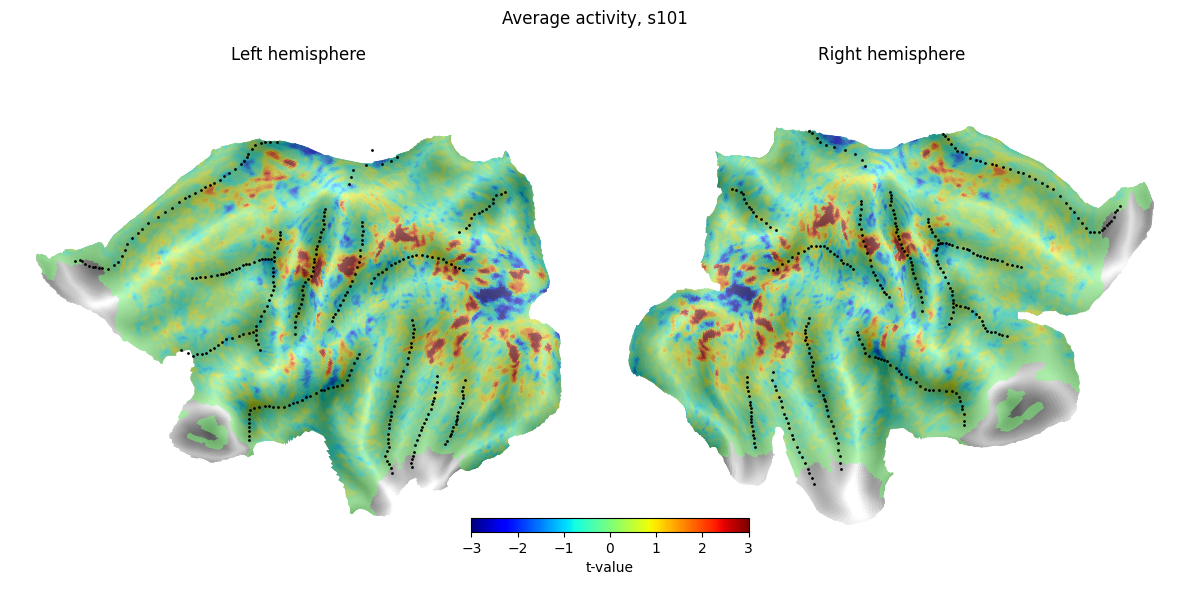

In [112]:
Hem = ['L', 'R']
region_names = ['?', 'S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', '?']
Hem = ['L', 'R']
borders = {'L': './surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border',
           'R': './surfAnalysisPy/standard_mesh/fs_R/fs_LR.32k.R.border'}

vmin, vmax = -3, 3
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, H in zip(axs, Hem):
    plt.sca(ax)
    surf.plot.plotmap(DL.mean(axis=1), f'fs32k_{H}',
                        underlay=None,
                        borders=borders[H],
                        cscale=[vmin, vmax],
                        cmap='jet',
                        underscale=[-1.5, 1],
                        alpha=.5,
                        new_figure=False,
                        colorbar=False,
                        # frame=[xlim[0], xlim[1], ylim[0], ylim[1]]
                        )
# make colorbar
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='jet')
cbar = fig.colorbar(sm, ax=[axs[0], axs[1]], orientation='horizontal', fraction=0.03)
cbar.set_label('t-value')

axs[0].set_title('Left hemisphere')
axs[1].set_title('Right hemisphere')
fig.suptitle(f'Average activity, s{sn}')
fig.tight_layout()
plt.savefig(f'./figures/glm{glm}_ses{ses}_spmT2surf.pdf', bbox_inches="tight")

## Y_adj

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_52896/3202991398.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  y_adj = np.nanmean(T_dict['y_adj'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == ch) & (T_dict['hem'] == Hem)).flatten()], axis=0)


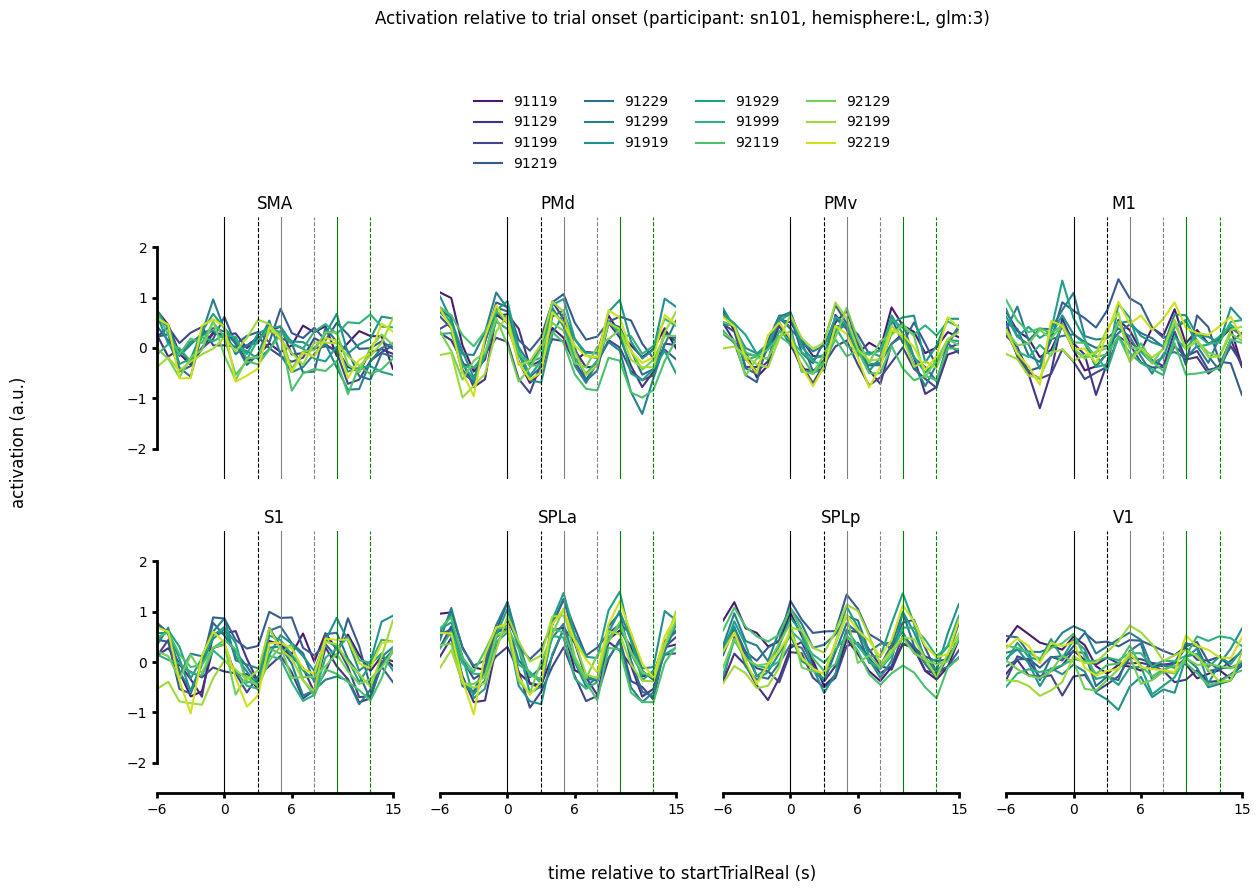

In [108]:
import scipy

Hem = 'L'
roi = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']
r = 0
glm = 3
ses = 1
sn=101

d = pd.read_table(os.path.join(baseDir, behavDir, f's{sn}', f'ses-{ses:02d}', f'efc4_101.dat'))
chordID = np.unique(d['chordID'].values)
chordID = chordID[0:13]
# chordID = chordID[13:26]
colors = sns.color_palette("viridis", n_colors=len(chordID))
mat = scipy.io.loadmat(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'hrf_glm{glm}.mat'))
T = mat['T'][0, 0]
T_fields = T.dtype.names
T_dict = {field: T[field] for field in T_fields}

tAx = np.linspace(-6, 15, 22)

fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(14, 9))
for i in range(2):
    for j in range(4):
        for cnt, ch in enumerate(chordID):
            y_adj = np.nanmean(T_dict['y_adj'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == ch) & (T_dict['hem'] == Hem)).flatten()], axis=0)
            # y_hat = np.nanmean(T_dict['y_hat'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == ch) &  (T_dict['hem'] == Hem)).flatten()], axis=0)

            axs[i, j].plot(tAx, y_adj, color=colors[cnt], label=ch, ls='-')
            # axs[i, j].plot(tAx, y_hat, color=gl.colour_mapping[f'glm{glm}'][f'chordID:{ch}'], label='go hat', ls='--')

        axs[i, j].axvline(0, color='k', ls='-', lw=.8)
        axs[i, j].axvline(3, color='k', ls='--', lw=.8)
        axs[i, j].axvline(5, color='grey', ls='-', lw=.8)
        axs[i, j].axvline(8, color='grey', ls='--', lw=.8)
        axs[i, j].axvline(10, color='g', ls='-', lw=.8)
        axs[i, j].axvline(13, color='g', ls='--', lw=.8)
        axs[i, j].set_title(roi[r])
        axs[i, j].set_xlim([-6, 15])
        axs[i, j].set_xticks([ -6, 0, 6, 15])

        # Remove unnecessary spines
        axs[i, j].spines['top'].set_visible(False)
        axs[i, j].spines['right'].set_visible(False)

        # Hide left and bottom spines based on row/column
        if i == 0:
            axs[i, j].spines['bottom'].set_visible(False)  # First row, hide bottom spine
        if j > 0:
            axs[i, j].spines['left'].set_visible(False)  # Hide left spines except first column

        # Hide ticks for non-left columns and first row
        if j > 0:
            axs[i, j].tick_params(axis='y', left=False)
        if i == 0:
            axs[i, j].tick_params(axis='x', bottom=False)

        r += 1

# Ensure left spines and ticks are visible for the first column
for i in range(2):
    axs[i, 0].spines['left'].set_visible(True)  # Show left spine for first column
    axs[i, 0].spines['left'].set_linewidth(2)  # Set left spine width for first column
    axs[i, 0].set_ylim([-2.6, 2.6])
    axs[i, 0].spines['left'].set_bounds([-2, 2])
    axs[i, 0].tick_params(axis='y', width=2)  # Show y-axis ticks for the first column
    
# Ensure bottom spines and ticks are visible for the second row
for j in range(4):
    axs[1, j].spines['bottom'].set_visible(True)  # Show bottom spine for second row
    axs[1, j].spines['bottom'].set_linewidth(2)  # Set bottom spine width for second row
    axs[1, j].spines['bottom'].set_bounds([-6, 15])
    axs[1, j].tick_params(axis='x', width=2)  # Show x-axis ticks for second row

# Legend and labels
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, .9), frameon=False)
fig.supylabel('activation (a.u.)')
fig.supxlabel('time relative to startTrialReal (s)')
fig.suptitle(f'Activation relative to trial onset (participant: sn{sn}, hemisphere:{Hem}, glm:{glm})')

fig.subplots_adjust(top=0.75)


## Y_adj vs Y_hat

/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_52896/3848467253.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  y_adj = np.nanmean(T_dict['y_adj'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == chordID) & (T_dict['hem'] == Hem)).flatten()], axis=0)
/var/folders/5y/1pn48fgn7yb77gc17h_5jms80000gp/T/ipykernel_52896/3848467253.py:23: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  y_hat = np.nanmean(T_dict['y_hat'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == chordID) &  (T_dict['hem'] == Hem)).flatten()], axis=0)


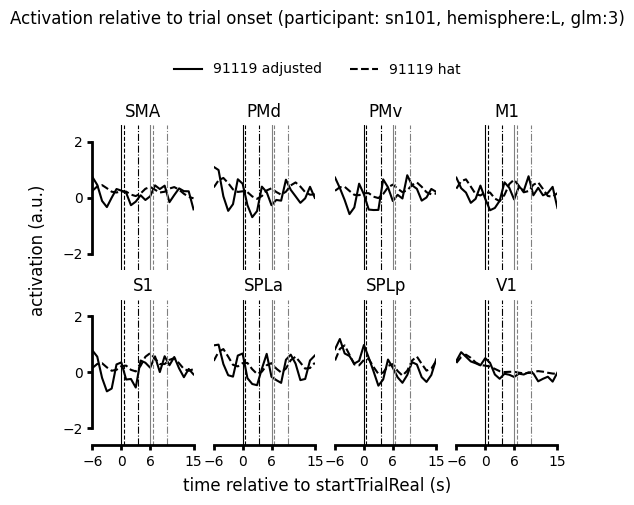

In [110]:
Hem = 'L'
roi = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']
r = 0
glm = 3
ses = 2
sn=101

d = pd.read_table(os.path.join(baseDir, behavDir, f's{sn}', f'ses-{ses:02d}', f'efc4_101.dat'))
chordID = np.unique(d['chordID'].values)
chordID = chordID[0]

mat = scipy.io.loadmat(os.path.join(baseDir, regDir, f's{sn}', f'ses-{ses:02d}', f'hrf_glm{glm}.mat'))
T = mat['T'][0, 0]
T_fields = T.dtype.names
T_dict = {field: T[field] for field in T_fields}

tAx = np.linspace(-6, 15, 22)

fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(6, 5))
for i in range(2):
    for j in range(4):
        y_adj = np.nanmean(T_dict['y_adj'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == chordID) & (T_dict['hem'] == Hem)).flatten()], axis=0)
        y_hat = np.nanmean(T_dict['y_hat'][((T_dict['name'] == roi[r]) & (T_dict['chordID'] == chordID) &  (T_dict['hem'] == Hem)).flatten()], axis=0)

        axs[i, j].plot(tAx, y_adj, color='k', label=f'{chordID} adjusted', ls='-')
        axs[i, j].plot(tAx, y_hat, color='k', label=f'{chordID} hat', ls='--')

        axs[i, j].axvline(0, color='k', ls='-', lw=.8)
        axs[i, j].axvline(.5, color='k', ls='--', lw=.8)
        axs[i, j].axvline(3.5, color='k', ls='-.', lw=.8)
        axs[i, j].axvline(6, color='grey', ls='-', lw=.8)
        axs[i, j].axvline(6.5, color='grey', ls='--', lw=.8)
        axs[i, j].axvline(9.5, color='grey', ls='-.', lw=.8)
        axs[i, j].set_title(roi[r])
        axs[i, j].set_xlim([-6, 15])
        axs[i, j].set_xticks([ -6, 0, 6, 15])

        # Remove unnecessary spines
        axs[i, j].spines['top'].set_visible(False)
        axs[i, j].spines['right'].set_visible(False)

        # Hide left and bottom spines based on row/column
        if i == 0:
            axs[i, j].spines['bottom'].set_visible(False)  # First row, hide bottom spine
        if j > 0:
            axs[i, j].spines['left'].set_visible(False)  # Hide left spines except first column

        # Hide ticks for non-left columns and first row
        if j > 0:
            axs[i, j].tick_params(axis='y', left=False)
        if i == 0:
            axs[i, j].tick_params(axis='x', bottom=False)

        r += 1

# Ensure left spines and ticks are visible for the first column
for i in range(2):
    axs[i, 0].spines['left'].set_visible(True)  # Show left spine for first column
    axs[i, 0].spines['left'].set_linewidth(2)  # Set left spine width for first column
    axs[i, 0].set_ylim([-2.6, 2.6])
    axs[i, 0].spines['left'].set_bounds([-2, 2])
    axs[i, 0].tick_params(axis='y', width=2)  # Show y-axis ticks for the first column

# Ensure bottom spines and ticks are visible for the second row
for j in range(4):
    axs[1, j].spines['bottom'].set_visible(True)  # Show bottom spine for second row
    axs[1, j].spines['bottom'].set_linewidth(2)  # Set bottom spine width for second row
    axs[1, j].spines['bottom'].set_bounds([-6, 15])
    axs[1, j].tick_params(axis='x', width=2)  # Show x-axis ticks for second row

# Legend and labels
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, .9), frameon=False)
fig.supylabel('activation (a.u.)')
fig.supxlabel('time relative to startTrialReal (s)')
fig.suptitle(f'Activation relative to trial onset (participant: sn{sn}, hemisphere:{Hem}, glm:{glm})')

fig.subplots_adjust(top=0.75)